# Random Forest – Détection d'URLs malveillantes

Ce notebook présente l'entraînement, l'évaluation et l'interprétation d'un modèle **Random Forest supervisé** pour la classification d'URLs en *benign*, *defacement*, *malware* et *phishing*.

Les cellules de texte expliquent **les résultats observés** lors de l'exécution.

# Partie 1 : Génération des Caractéristiques (Feature Engineering)


In [ ]:
import pandas as pd
import numpy as np
import re
import tldextract
from urllib.parse import urlparse
from collections import Counter
from tqdm import tqdm
tqdm.pandas()

# ---------------------------------------------------------
# Fonctions utilitaires
# ---------------------------------------------------------
def shannon_entropy(s):
    if not s:
        return 0
    counts = Counter(s)
    length = len(s)
    return -sum((c/length) * np.log2(c/length) for c in counts.values())


def ngram_entropy(s, n=2):
    if len(s) < n:
        return 0
    ngrams = [s[i:i+n] for i in range(len(s)-n+1)]
    counts = Counter(ngrams)
    total = len(ngrams)
    return -sum((c/total) * np.log2(c/total) for c in counts.values())


def transition_score(s):
    if len(s) < 2:
        return 0
    transitions = [(s[i], s[i+1]) for i in range(len(s) - 1)]
    return len(set(transitions)) / len(transitions)

def consonant_vowel_ratio(s):
    vowels = "aeiou"
    v = sum(c in vowels for c in s.lower())
    c = sum(c.isalpha() and c not in vowels for c in s.lower())
    return c / (v + 1)

def longest_alpha_sequence(s):
    seqs = re.findall(r"[a-zA-Z]+", s)
    return max((len(x) for x in seqs), default=0)

# ---------------------------------------------------------
# Extraction complète des features d'une URL
# ---------------------------------------------------------
def extract_url_features(url):
    fe = {}

    if not isinstance(url, str):
        url = ""

    parsed = urlparse(url)
    ext = tldextract.extract(url)

    domain = ext.domain
    path = parsed.path
    query = parsed.query

    # ---------------------------------------------------------
    # 1. Longueurs (6)
    # ---------------------------------------------------------
    fe["url_length"] = len(url)
    fe["domain_length"] = len(domain)
    fe["subdomain_length"] = len(ext.subdomain)
    fe["suffix_length"] = len(ext.suffix)
    fe["path_length"] = len(path)
    fe["query_length"] = len(query)

    # ---------------------------------------------------------
    # 2. Comptages caractères (9)
    # ---------------------------------------------------------
    fe["count_dot"] = url.count(".")
    fe["count_slash"] = url.count("/")
    fe["count_dash"] = url.count("-")
    fe["count_at"] = url.count("@")
    fe["count_pct"] = url.count("%")
    fe["count_equal"] = url.count("=")
    fe["count_question"] = url.count("?")
    fe["count_underscore"] = url.count("_")
    fe["count_digit"] = sum(c.isdigit() for c in url)
    fe["count_alpha"] = sum(c.isalpha() for c in url)

    # ---------------------------------------------------------
    # 3. Ratios (5)
    # ---------------------------------------------------------
    fe["digit_ratio"] = fe["count_digit"] / fe["url_length"] if fe["url_length"] > 0 else 0
    fe["alpha_ratio"] = fe["count_alpha"] / fe["url_length"] if fe["url_length"] > 0 else 0
    fe["special_ratio"] = (
        fe["count_dash"] + fe["count_at"] + fe["count_pct"] + fe["count_underscore"]
    ) / fe["url_length"] if fe["url_length"] > 0 else 0

    # ---------------------------------------------------------
    # 4. Entropies (ordre pris en compte) (6)
    # ---------------------------------------------------------
    fe["entropy_url"] = shannon_entropy(url)
    fe["entropy_domain"] = shannon_entropy(domain)
    fe["entropy_path"] = shannon_entropy(path)

    fe["entropy_bigram"] = ngram_entropy(url, 2)
    fe["entropy_trigram"] = ngram_entropy(url, 3)

    fe["transition_score"] = transition_score(url)

    # ---------------------------------------------------------
    # 5. Linguistique / structure (5)
    # ---------------------------------------------------------
    fe["consonant_vowel_ratio"] = consonant_vowel_ratio(domain)
    fe["longest_alpha_sequence"] = longest_alpha_sequence(url)

    fe["path_depth"] = path.count("/")
    fe["num_tokens"] = len(re.split(r"[./\-_=]", url))
    fe["num_path_tokens"] = len(re.split(r"[./\-_=]", path))

    # ---------------------------------------------------------
    # 6. Patterns suspects (8)
    # ---------------------------------------------------------
    fe["has_ip"] = 1 if re.match(r"^\d+\.\d+\.\d+\.\d+", ext.domain) else 0
    fe["has_https"] = 1 if parsed.scheme == "https" else 0
    fe["has_http"] = 1 if parsed.scheme == "http" else 0
    fe["has_multiple_subdomains"] = 1 if ext.subdomain.count(".") >= 1 else 0

    fe["has_login"] = int("login" in url.lower())
    fe["has_verify"] = int("verify" in url.lower())
    fe["has_update"] = int("update" in url.lower())
    fe["has_secure"] = int("secure" in url.lower())

    # ---------------------------------------------------------
    # 7. Marques connues (spoofing) (3)
    # ---------------------------------------------------------
    brands = ["paypal", "google", "facebook", "apple", "amazon", "microsoft", "wikipedia"]
    fe["brand_in_url"] = int(any(b in url.lower() for b in brands))
    fe["brand_in_domain"] = int(any(b in domain.lower() for b in brands))
    fe["brand_in_path"] = int(any(b in path.lower() for b in brands))

    # ---------------------------------------------------------
    # 8. Paramètres suspects (2)
    # ---------------------------------------------------------
    fe["num_params"] = query.count("=")
    fe["has_long_param"] = int(any(len(p) > 20 for p in query.split("=")))

    # ---------------------------------------------------------
    # 9. TLD suspects (1)
    # ---------------------------------------------------------
    suspicious_tlds = ["ru", "cn", "tk", "ml", "ga", "cf"]
    fe["suspicious_tld"] = int(ext.suffix in suspicious_tlds)

    return fe

# ---------------------------------------------------------
# Chargement du dataset
# ---------------------------------------------------------
df = pd.read_csv("malicious_phish.csv")  # doit contenir: url, label

# ---------------------------------------------------------
# Extraction des features
# ---------------------------------------------------------
features = df["url"].progress_apply(extract_url_features).apply(pd.Series)

df_final = pd.concat([df, features], axis=1)

# ---------------------------------------------------------
# Sauvegarde
# ---------------------------------------------------------
df_final.to_csv("dataset_enriched.csv", index=False)

print("Extraction terminée !")
print("Nombre de colonnes :", df_final.shape[1])
print(df_final.head())

# Partie 2 : Classification Random Forest

Maintenant que nous avons généré nos caractéristiques, nous allons entraîner un modèle Random Forest pour classifier les URLs en quatre catégories : bénignes, defacement, malware et phishing.

In [18]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

## 1️⃣ Chargement du dataset

Le dataset enrichi contient des URLs accompagnées de **44 features** statistiques, structurelles, entropiques et linguistiques.

➡️ Taille totale : **~650 000 URLs**.

In [19]:
df = pd.read_csv("./2.4_Part2_dataset/dataset_enriched.csv")
print("Dataset chargé :", df.shape)


Dataset chargé : (651191, 46)


## 2️⃣ Sélection des features et du label

Les features couvrent :
- longueurs et comptages de caractères
- ratios numériques / alphabétiques
- mesures d'entropie
- patterns suspects (IP, HTTPS, mots-clés)
- indicateurs de marques et TLD suspects

Le label `type` indique la classe réelle de l'URL.

In [20]:
FEATURE_COLUMNS = [
    "url_length", "domain_length", "subdomain_length", "suffix_length",
    "path_length", "query_length",
    "count_dot", "count_slash", "count_dash", "count_at", "count_pct",
    "count_equal", "count_question", "count_underscore", "count_digit",
    "count_alpha",
    "digit_ratio", "alpha_ratio", "special_ratio",
    "entropy_url", "entropy_domain", "entropy_path",
    "entropy_bigram", "entropy_trigram", "transition_score",
    "consonant_vowel_ratio", "longest_alpha_sequence",
    "path_depth", "num_tokens", "num_path_tokens",
    "has_ip", "has_https", "has_http", "has_multiple_subdomains",
    "has_login", "has_verify", "has_update", "has_secure",
    "brand_in_url", "brand_in_domain", "brand_in_path",
    "num_params", "has_long_param",
    "suspicious_tld",
]

X = df[FEATURE_COLUMNS]
y = df["type"]  # Les vraies labels pour évaluation


## 3️⃣ Nettoyage minimal

Les valeurs manquantes sont remplacées par **0**, ce qui est acceptable pour des features numériques dérivées de chaînes de caractères.

In [21]:

X = X.fillna(0)


## 4️⃣ Préparation des données pour Isolation Forest


 Isolation Forest fonctionne mieux en détection d'anomalies binaire
 Nous allons créer un label binaire : 1 pour normal (benign), -1 pour anomalie (malware, phishing, defacement)

In [22]:
y_binary = np.where(y == 'benign', 1, -1)

# Séparation Train/Test (stratifiée sur le label binaire)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary,
    test_size=0.2,
    random_state=42,
    stratify=y_binary
)

print("Train size :", X_train.shape)
print("Test size  :", X_test.shape)
print(f"Distribution dans le train : {np.unique(y_train, return_counts=True)}")

Train size : (520952, 44)
Test size  : (130239, 44)
Distribution dans le train : (array([-1,  1]), array([178470, 342482]))


## 5️⃣ Entraînement de l'Isolation Forest

 Isolation Forest est idéal pour détecter des anomalies dans des données haute dimension
 Paramètres clés :
 - contamination : proportion estimée d'anomalies dans les données
 - n_estimators : nombre d'arbres
 - max_samples : taille de l'échantillon pour chaque arbre

In [23]:
contamination_est = np.sum(y_train == -1) / len(y_train)

model = IsolationForest(
    n_estimators=300,           # Nombre d'arbres (comme Random Forest)
    max_samples='auto',         # Taille de l'échantillon pour chaque arbre
    contamination=contamination_est,  # Proportion d'anomalies estimée
    max_features=1.0,          # Utilise toutes les features
    bootstrap=False,           # Échantillonnage sans remplacement
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Entraînement de l'Isolation Forest...")
model.fit(X_train)
print("Entraînement terminé")


Entraînement de l'Isolation Forest...


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.7s remaining:    4.1s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    4.7s


Entraînement terminé


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    7.3s finished


## 6️⃣ Évaluation du modèle

 Prédiction : 1 pour normal, -1 pour anomalie


In [24]:
y_pred = model.predict(X_test)

# Scores d'anomalie (plus négatif = plus anormal)
anomaly_scores = model.decision_function(X_test)

print(f"\nPrédictions : {np.unique(y_pred, return_counts=True)}")
print(f"Réels       : {np.unique(y_test, return_counts=True)}")


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.1s



Prédictions : (array([-1,  1]), array([44325, 85914]))
Réels       : (array([-1,  1]), array([44618, 85621]))


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.7s finished


# 7️⃣ Métriques de performance


In [25]:
print("\n=== Métriques de Détection d'Anomalies ===\n")

# Matrice de confusion
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

# Rapport de classification
print("\nRapport de classification :")
print(classification_report(y_test, y_pred, 
                          target_names=['Anomalie (-1)', 'Normal (1)']))



=== Métriques de Détection d'Anomalies ===

Matrice de confusion :
[[20161 24457]
 [24164 61457]]

Rapport de classification :
               precision    recall  f1-score   support

Anomalie (-1)       0.45      0.45      0.45     44618
   Normal (1)       0.72      0.72      0.72     85621

     accuracy                           0.63    130239
    macro avg       0.59      0.58      0.58    130239
 weighted avg       0.63      0.63      0.63    130239



# 8️⃣ Analyse des scores d'anomalie


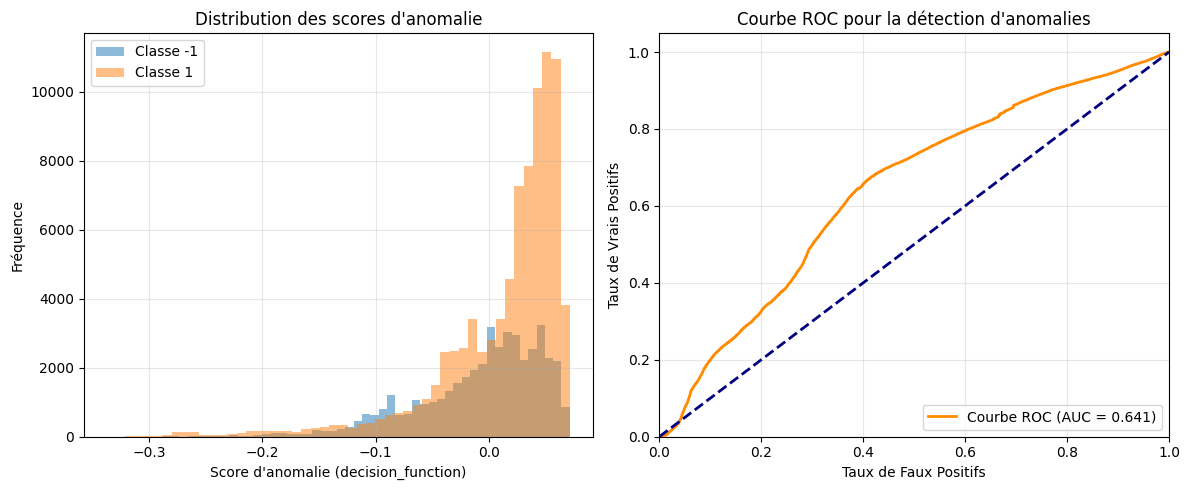


AUC Score: 0.6415


In [26]:
plt.figure(figsize=(12, 5))

# Distribution des scores par classe réelle
plt.subplot(1, 2, 1)
for label in [-1, 1]:
    mask = y_test == label
    plt.hist(anomaly_scores[mask], alpha=0.5, 
             label=f'Classe {label}', bins=50)
plt.xlabel('Score d\'anomalie (decision_function)')
plt.ylabel('Fréquence')
plt.title('Distribution des scores d\'anomalie')
plt.legend()
plt.grid(alpha=0.3)

# Courbe ROC
plt.subplot(1, 2, 2)
# Pour la courbe ROC, nous avons besoin de scores de probabilité
# Les anomalies doivent être positives (1) pour sklearn
roc_labels = np.where(y_test == -1, 1, 0)  # Anomalie = 1, Normal = 0
roc_scores = -anomaly_scores  # Inverser les scores (plus élevé = plus anormal)

fpr, tpr, thresholds = roc_curve(roc_labels, roc_scores)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'Courbe ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC pour la détection d\'anomalies')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAUC Score: {roc_auc:.4f}")


# 🔟 Sauvegarde du modèle

In [ ]:
joblib.dump(model, "isolation_forest_url.pkl")
joblib.dump(FEATURE_COLUMNS, "if_features.pkl")

print("Modèle sauvegardé : isolation_forest_url.pkl")
print("Features sauvegardées : if_features.pkl")



# Partie 3 : Analyse Exploratoire et Détection d'Anomalies

In [12]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, auc,
    classification_report,
    precision_score, recall_score, f1_score
)
from scipy.stats.mstats import winsorize

warnings.filterwarnings('ignore')


In [13]:

print("Chargement des données...")
df = pd.read_csv("./2.4_Part2_dataset/dataset_enriched.csv")
print(f"Dataset chargé : {df.shape[0]} URLs, {df.shape[1]} colonnes")

features = df.drop(columns=["url", "type"])
labels = df["type"]


Chargement des données...
Dataset chargé : 651191 URLs, 46 colonnes


In [14]:

scaler_global = StandardScaler()
X_scaled = scaler_global.fit_transform(features)


PCA 2D...


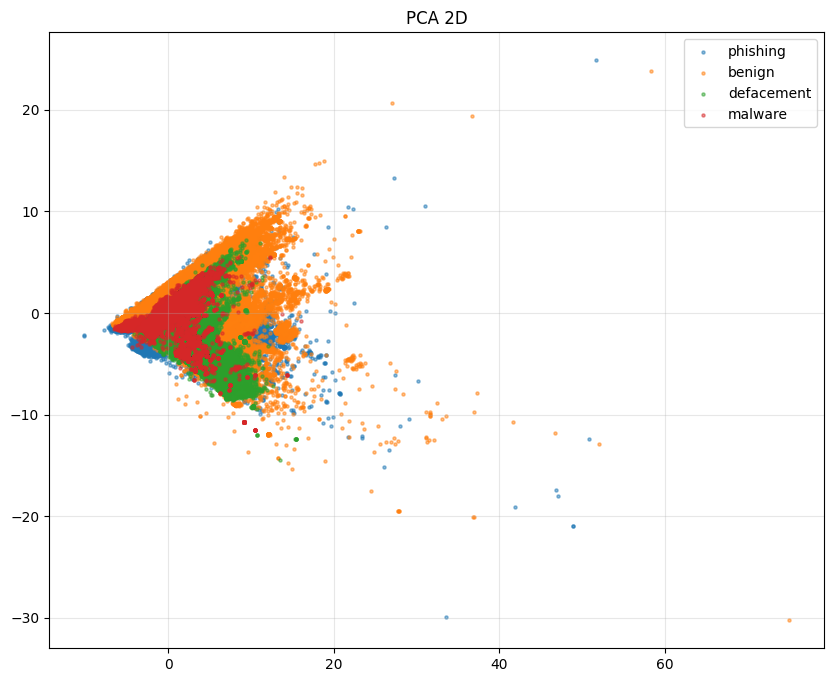

In [15]:

print("PCA 2D...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,8))
for label in labels.unique():
    mask = labels == label
    plt.scatter(X_pca[mask,0], X_pca[mask,1], s=5, alpha=0.5, label=label)

plt.legend()
plt.title("PCA 2D")
plt.grid(alpha=0.3)
plt.show()


t-SNE (échantillon)...


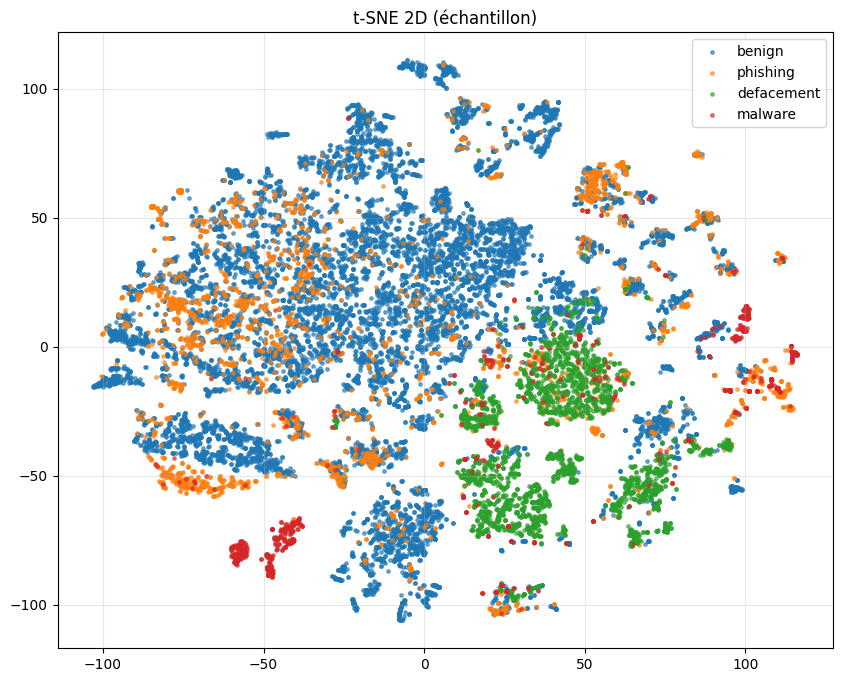

In [16]:

print("t-SNE (échantillon)...")
sample_size = min(20000, len(X_scaled))

X_sample, _, y_sample, _ = train_test_split(
    X_scaled, labels,
    train_size=sample_size,
    stratify=labels,
    random_state=42
)

tsne = TSNE(
    n_components=2,
    perplexity=min(30, sample_size // 3),
    init='pca',
    learning_rate='auto',
    random_state=42
)

X_tsne = tsne.fit_transform(X_sample)

plt.figure(figsize=(10,8))
for label in y_sample.unique():
    mask = y_sample == label
    plt.scatter(X_tsne[mask,0], X_tsne[mask,1], s=6, alpha=0.6, label=label)

plt.legend()
plt.title("t-SNE 2D (échantillon)")
plt.grid(alpha=0.3)
plt.show()
